In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
n_subjects = len(subjects)
# subjects = np.arange(1,4)

fitting_type = 'gabor_solo_ridge_12ori_8sf_plus_texture_pyramid_ridge_4ori_4sf_pca_HL'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois



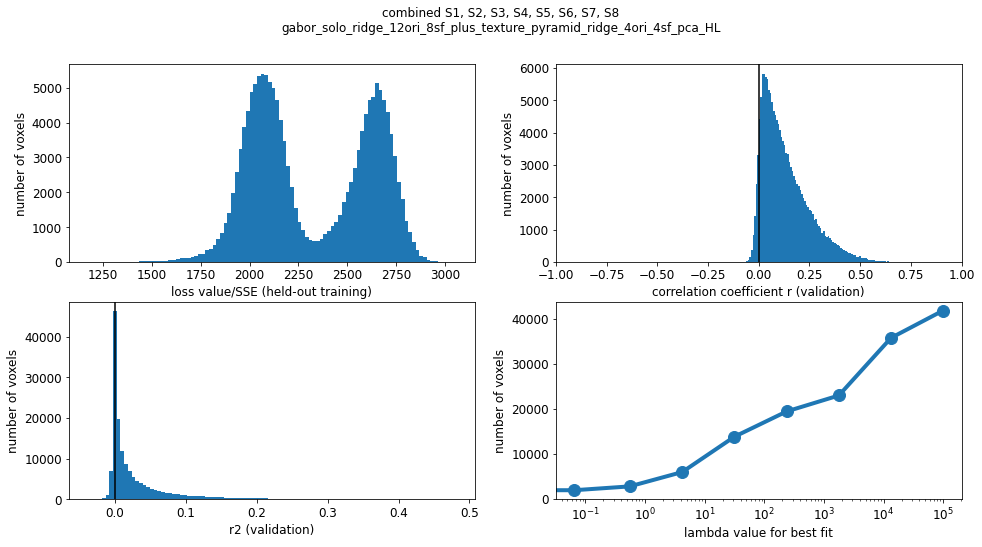

In [3]:
plot_utils.set_all_font_sizes(12)
summary_plots.plot_perf_summary(fitting_type, out)

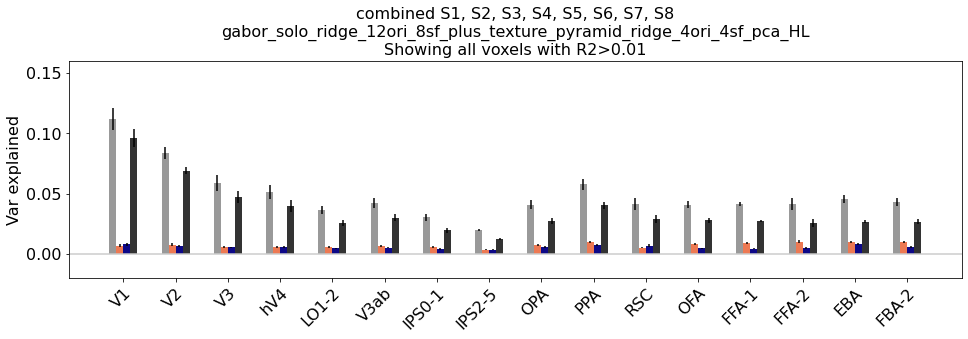

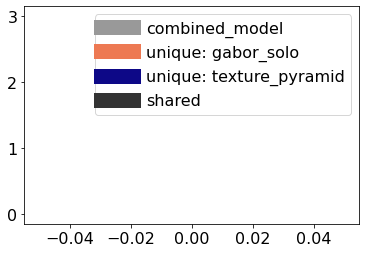

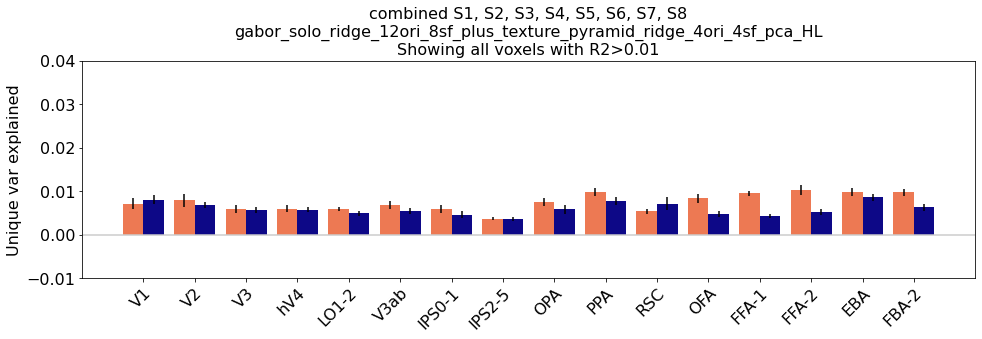

In [4]:
# Make a barplot for variance partition across all ROIs and subjects

r2_thresh = 0.01

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out[0]['partial_version_names'][pp1].split('just_')[1]
name2 = out[0]['partial_version_names'][pp2].split('just_')[1]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
    var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
            
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Var explained', \
                ylim=[-0.02, 0.16], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

plot_utils.plot_multi_bars(mean_data=mean_vals[:,1:3], err_data=sem_vals[:,1:3], \
                           colors=colors[1:3,:], space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.04], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(ve_names)[1:3], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4))





['just_texture_pyramid'
 'texture_pyramid_just_higher-level_plus_other_modules'
 'texture_pyramid_just_lower-level_plus_other_modules']
[641, 688, 145]
[96, 49, 592]


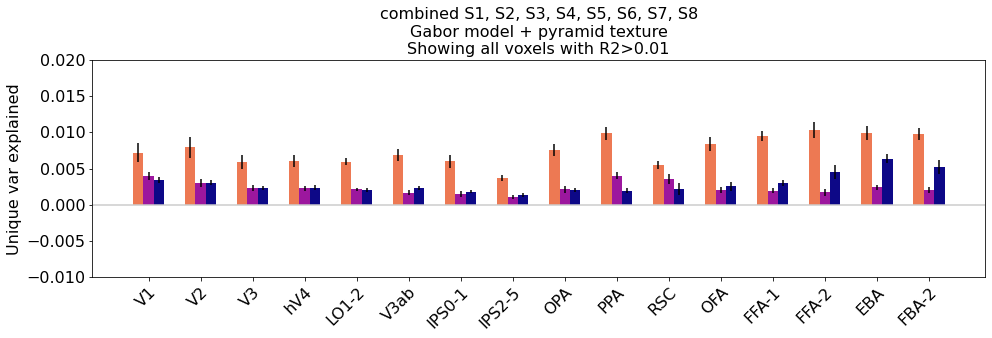

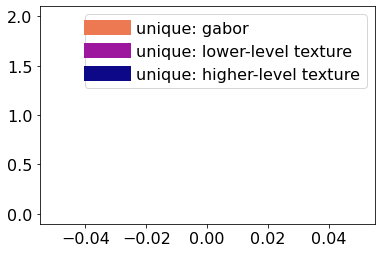

In [7]:
# Make a barplot for variance partition across all ROIs and subjects
r2_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,6,5]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', 'unique: higher-level texture']

colors = np.flipud(cm.plasma(np.linspace(0,1,4))[0:3,:])

vals = np.zeros((n_subjects, n_rois, 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,3]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\nGabor model + pyramid texture\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.02], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))
